In [2]:
# Setup
import pandas as pd
import numpy as np
import git
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as T

import matplotlib.pyplot as plt
%matplotlib inline

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
dtype=torch.float32

from barebone import *
from model_util import *

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Load keypoints

In [7]:
subjects = np.load("{}/preprocessing/poseformer/subjects.npy".format(homedir))
keypoints3d = np.load("{}/preprocessing/poseformer/joints_3d_padded.npy".format(homedir))
print(keypoints3d.shape)

(384, 1511, 17, 3)


In [8]:
num_samples = keypoints3d.shape[0]
keypoints3d = keypoints3d.reshape((num_samples, -1))      # Flatten frame, joint and coordinates
df_kp3d = pd.DataFrame(keypoints3d)
df_kp3d.insert(0, 'subjectid', subjects)

df_kp3d

,subjectid,0,1,2,3,4,5,6,7,8,...,77051,77052,77053,77054,77055,77056,77057,77058,77059,77060
0,kEC7G8DP,0.0,0.0,0.553803,0.118477,0.048315,0.559740,0.078025,0.448527,0.405209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GjPHiGli,0.0,0.0,0.743547,0.134699,0.026321,0.732065,-0.058176,0.387448,0.505844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,RFibHPt7,0.0,0.0,0.603302,0.016389,0.139365,0.610147,-0.268166,0.238692,0.415880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,gO7Cpt1X,0.0,0.0,0.567537,0.071610,-0.120018,0.568075,0.469379,0.117718,0.449701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,xEIsrkiR,0.0,0.0,0.576566,0.126515,-0.013554,0.562857,0.010256,0.230066,0.288412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,VID_20230506_175810340,0.0,0.0,1.006987,0.139903,-0.019908,0.980886,0.106557,0.084857,0.421844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
380,8elUiJYv,0.0,0.0,0.630345,0.098289,0.083985,0.633622,0.120486,0.398054,0.393028,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
381,PXL_20230505_234002299,0.0,0.0,0.920654,0.071631,-0.096997,0.898501,0.042036,-0.115334,0.418619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
382,q8FyLMSn,0.0,0.0,0.620147,0.140228,0.037624,0.613141,0.192907,0.430776,0.407713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Load Survey Data (labels)

In [5]:
df_survey = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/survey_data.csv')
df_survey

,subjectid,OA_check
0,kGhQ1FQc,1
1,KyINSk8e,0
2,ybGzWMPA,0
3,b632WDpF,0
4,UDXlpEgF,0
...,...,...
400,tFSyXitq,1
401,OuYG4U64,0
402,nM7tQcBS,0
403,zN0O4jLu,0


### Preprocessing 

- Create train/val/test sets
- Normalization
- Oversampling
- Hand-pick features

In [9]:
# join the dataframes by subjectId 
df_join = df_kp3d.set_index('subjectid').join(df_survey.set_index('subjectid')).astype('float32')
df_join

,0,1,2,3,4,5,6,7,8,9,...,77052,77053,77054,77055,77056,77057,77058,77059,77060,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
kEC7G8DP,0.0,0.0,0.553803,0.118477,0.048315,0.559740,0.078025,0.448527,0.405209,0.135244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GjPHiGli,0.0,0.0,0.743547,0.134699,0.026321,0.732065,-0.058176,0.387448,0.505844,0.043619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RFibHPt7,0.0,0.0,0.603302,0.016389,0.139365,0.610147,-0.268166,0.238692,0.415880,-0.284261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gO7Cpt1X,0.0,0.0,0.567537,0.071610,-0.120018,0.568075,0.469379,0.117718,0.449701,0.328360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xEIsrkiR,0.0,0.0,0.576566,0.126515,-0.013554,0.562857,0.010256,0.230066,0.288412,0.128244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VID_20230506_175810340,0.0,0.0,1.006987,0.139903,-0.019908,0.980886,0.106557,0.084857,0.421844,-0.013960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
8elUiJYv,0.0,0.0,0.630345,0.098289,0.083985,0.633622,0.120486,0.398054,0.393028,0.052458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PXL_20230505_234002299,0.0,0.0,0.920654,0.071631,-0.096997,0.898501,0.042036,-0.115334,0.418619,-0.127163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [5]:
# all videos from the new clinical trial have OA=1 
df_join = df_join.fillna(value={'OA_check': 1})
df_join

,time,time_diff,speed,time_sd,speed_sd,n_sit2stand,time_sit2stand,time_diff_sit2stand,speed_sit2stand,time_sd_sit2stand,...,ank_to_hip_dist_sit,ank_to_hip_dist_stand,knee_to_hip_dist_sit,knee_to_hip_dist_stand,height,lknee_angle_first_sit,rknee_angle_first_sit,lknee_angle_first_stand,rknee_angle_first_stand,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
kEC7G8DP,11.666667,0.391667,0.43,0.568429,0.109845,5.0,5.000000,-0.083333,1.00,0.164655,...,1.592739,3.180187,1.704116,2.036679,0.915840,126.157028,163.349762,193.017014,163.114975,0.0
GjPHiGli,14.033334,-0.066667,0.36,0.247117,0.030709,5.0,5.266667,-0.791667,0.95,0.203961,...,1.627585,1.900191,1.513419,1.420853,0.918023,111.429863,128.344070,178.385574,180.138870,0.0
RFibHPt7,13.833333,-0.241667,0.36,0.374166,0.059231,5.0,4.333333,-1.166667,1.15,0.180123,...,1.376164,1.563910,1.026070,1.518753,0.971309,96.485191,94.164581,168.988907,177.376358,0.0
gO7Cpt1X,11.500000,0.283333,0.43,0.733333,0.190154,5.0,3.900000,-0.866667,1.28,0.381576,...,1.296188,1.158777,1.313558,1.067322,0.925391,102.517990,113.330788,181.267090,214.777405,0.0
xEIsrkiR,12.266666,-0.500000,0.41,0.972420,0.342664,5.0,2.233333,-2.000000,2.24,0.149963,...,0.986963,1.307289,0.568683,0.639755,0.970054,151.456741,138.360947,201.445511,178.812073,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VID_20230506_175810340,15.366667,-0.511111,0.26,0.682469,0.058440,4.0,5.966667,-1.311111,0.67,0.189113,...,0.831932,1.170661,0.644232,1.117247,0.956355,131.244125,104.038109,173.939682,191.231750,1.0
8elUiJYv,7.400000,0.108333,0.68,0.209338,0.106825,5.0,4.000000,0.100000,1.25,0.172562,...,7.196703,0.972598,3.195569,2.493561,0.954803,108.555145,147.880615,130.857803,188.354355,0.0
PXL_20230505_234002299,14.300000,-0.544444,0.28,0.718554,0.077061,4.0,4.900000,-1.655556,0.82,0.317433,...,0.760820,0.755019,0.969426,1.280454,0.941937,100.971542,108.121826,173.023621,204.930389,1.0


#### Data validation 

In [6]:
# do a stratified split so that each dataset has the same proportion of OA=0 and OA=1
y = df_join['OA_check']

# set a random seed for reproducibility 
np.random.seed(42)

# split out test set from train/val
train_val_indices, test_indices = train_test_split(np.arange(len(df_join)), test_size=0.1, stratify=y)

# split out val set from train
train_ind, val_ind = train_test_split(np.arange(len(train_val_indices)), test_size=0.11111, stratify=y[train_val_indices])
train_indices = train_val_indices[train_ind]
val_indices = train_val_indices[val_ind]

In [7]:
# 384 examples 
NUM_TRAIN = len(train_indices)
NUM_VAL = len(val_indices)

train_data = df_join.iloc[train_indices]
val_data = df_join.iloc[val_indices]
test_data = df_join.iloc[test_indices]

In [8]:
# Check for number of OA positive and number of samples in the dataset
# Total - 78% OA=0, 22% OA=1
print(df_join.iloc[:,-1].count())  # 384
print(df_join.iloc[:,-1].sum())    # 84
class_counts = [df_join.iloc[:,-1].count() - df_join.iloc[:,-1].sum(), df_join.iloc[:,-1].sum()]

# Train set - This implies that if the model always predicts 0, it would have 78% training accuracy
print(train_data.iloc[:,-1].count())  # 306
print(train_data.iloc[:,-1].sum())    # 67

# Validation set - This implies that if the model always predicts 0, it would have 79% val accuracy
print(val_data.iloc[:,-1].count())  # 39
print(val_data.iloc[:,-1].sum())    # 8

# Test set - This implies that if the model always predicts 0, it would have 77% test accuracy
print(test_data.iloc[:,-1].count())  # 39
print(test_data.iloc[:,-1].sum())    # 9

384
84.0
306
67.0
39
8.0
39
9.0


#### Normalization

In [10]:
# compute mean and std of the features 
means = []
stds = []
for column in train_data.iloc[:,:-1]: # only use training set, and exclude last column, which has labels
    column_np = train_data[column].to_numpy()
    means.append(np.mean(column_np))
    stds.append(np.std(column_np))
    
# apply normalization
def transform(feature): 
    return (feature - means) / stds

#### Create dataloaders

In [11]:
# with normalization, no oversampling
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

In [12]:
for i, (data, labels) in enumerate(loader_train):
  print(data.shape, labels.shape)
  print(data,labels)
  break

torch.Size([64, 448]) torch.Size([64])
tensor([[ 5.1767e-02, -1.3801e-01, -2.6823e-01,  ..., -4.3148e-01,
         -1.1086e-01, -2.4702e-01],
        [-1.0200e+00,  5.0738e-01,  1.0988e+00,  ..., -2.0620e-01,
          9.1392e-04, -1.4618e-01],
        [ 5.6042e-01, -1.0907e+00, -6.2483e-01,  ...,  5.4433e-01,
         -3.2703e+00, -4.6082e+00],
        ...,
        [ 1.4260e-01, -4.4533e-01, -3.2766e-01,  ..., -6.5655e-03,
         -7.8719e-01,  1.7852e-01],
        [ 1.0055e+00, -1.4288e+00, -8.6257e-01,  ...,  5.6187e+00,
          7.4769e-01, -2.8860e-01],
        [ 4.0600e-01, -1.1522e+00, -5.0597e-01,  ...,  7.5518e-01,
         -7.5982e-02,  5.0863e-01]]) tensor([0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 1.])


#### Create dataloaders with upsampling 

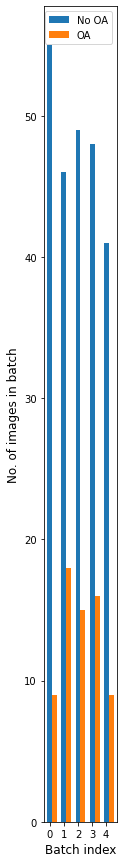

Avg Proportion of No OA per batch: 4.779999999999999
Avg Proportion of OA per batch: 1.3400000000000003
Num. unique images seen: 207/306


In [16]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# visualize training data imbalance
_, _, _ = visualise_dataloader(loader_train, {0: "No OA", 1: "OA"})

<ipython-input-17-8623099a84a5>:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  class_weights_all = class_weights[labels]


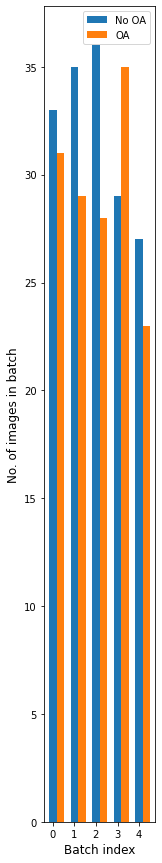

Avg Proportion of No OA per batch: 3.2
Avg Proportion of OA per batch: 2.9200000000000004
Num. unique images seen: 134/306


In [17]:
train = CustomDataset(dataframe=train_data, transform=transform)
class_weights = 1./torch.tensor(class_counts, dtype=torch.float) 
labels = train_data.iloc[:,-1]
class_weights_all = class_weights[labels]

# oversample the training data 
weighted_sampler = sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

_, _, _ = visualise_dataloader(loader_train_os, {0: "No OA", 1: "OA"})

### BareBones Model

#### Train model with normalized inputs, no oversampling

In [18]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 77061
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=20)

Epoch 0, loss = 0.6548, train_acc = 77.7778, val_acc = 76.9231, train_pos = 1.6340, val_pos = 2.5641
Epoch 1, loss = 0.6121, train_acc = 79.0850, val_acc = 79.4872, train_pos = 0.9804, val_pos = 0.0000
Epoch 2, loss = 0.5566, train_acc = 79.4118, val_acc = 76.9231, train_pos = 1.3072, val_pos = 2.5641
Epoch 3, loss = 0.5684, train_acc = 80.0654, val_acc = 76.9231, train_pos = 2.6144, val_pos = 2.5641
Epoch 4, loss = 0.5507, train_acc = 80.3922, val_acc = 76.9231, train_pos = 2.9412, val_pos = 2.5641
Epoch 5, loss = 0.5356, train_acc = 80.3922, val_acc = 76.9231, train_pos = 2.9412, val_pos = 2.5641
Epoch 6, loss = 0.4817, train_acc = 80.3922, val_acc = 76.9231, train_pos = 2.9412, val_pos = 2.5641
Epoch 7, loss = 0.4762, train_acc = 80.7190, val_acc = 76.9231, train_pos = 2.6144, val_pos = 2.5641
Epoch 8, loss = 0.4657, train_acc = 80.7190, val_acc = 76.9231, train_pos = 2.6144, val_pos = 2.5641
Epoch 9, loss = 0.4735, train_acc = 81.0458, val_acc = 76.9231, train_pos = 2.9412, val_pos

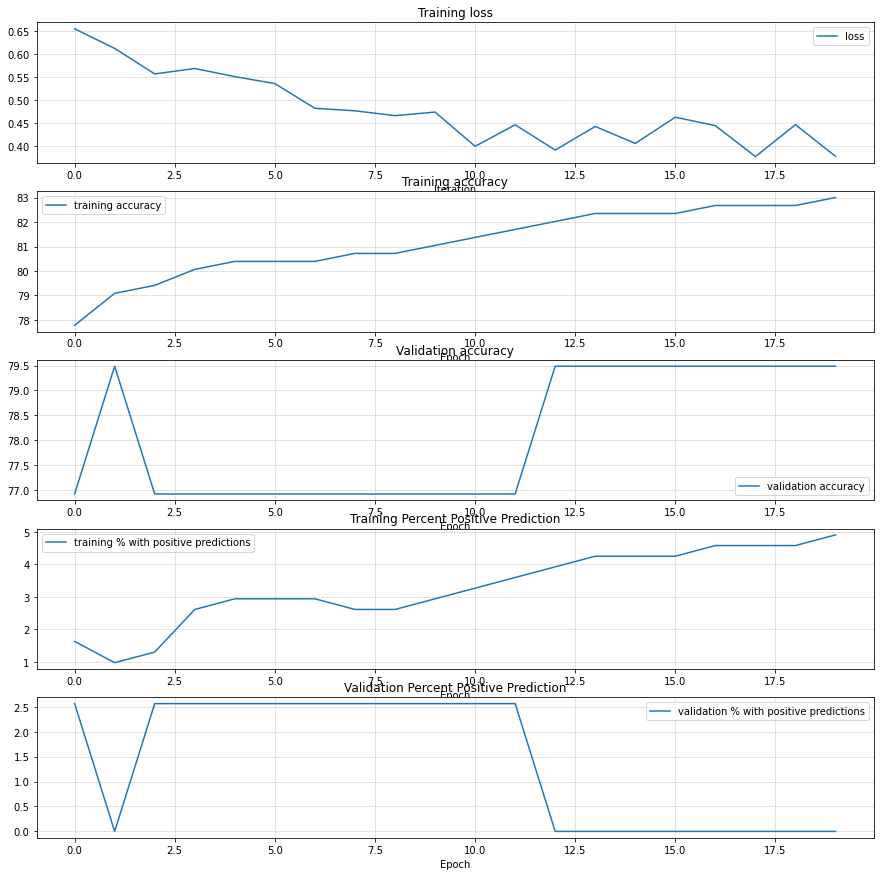

In [19]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs on oversampled training set

In [20]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 77061
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os, loader_val, epochs=50)

Epoch 0, loss = 0.6247, train_acc = 54.2484, val_acc = 79.4872, train_pos = 1.6340, val_pos = 5.1282
Epoch 1, loss = 0.6202, train_acc = 53.9216, val_acc = 79.4872, train_pos = 8.8235, val_pos = 5.1282
Epoch 2, loss = 0.6139, train_acc = 66.0131, val_acc = 76.9231, train_pos = 14.3791, val_pos = 12.8205
Epoch 3, loss = 0.5753, train_acc = 64.3791, val_acc = 82.0513, train_pos = 15.3595, val_pos = 12.8205
Epoch 4, loss = 0.6209, train_acc = 67.6471, val_acc = 84.6154, train_pos = 19.2810, val_pos = 15.3846
Epoch 5, loss = 0.5333, train_acc = 71.5686, val_acc = 84.6154, train_pos = 24.5098, val_pos = 15.3846
Epoch 6, loss = 0.5541, train_acc = 72.5490, val_acc = 82.0513, train_pos = 24.8366, val_pos = 17.9487
Epoch 7, loss = 0.5076, train_acc = 76.7974, val_acc = 82.0513, train_pos = 29.0850, val_pos = 17.9487
Epoch 8, loss = 0.5147, train_acc = 74.1830, val_acc = 82.0513, train_pos = 31.6993, val_pos = 23.0769
Epoch 9, loss = 0.4818, train_acc = 79.0850, val_acc = 84.6154, train_pos = 3

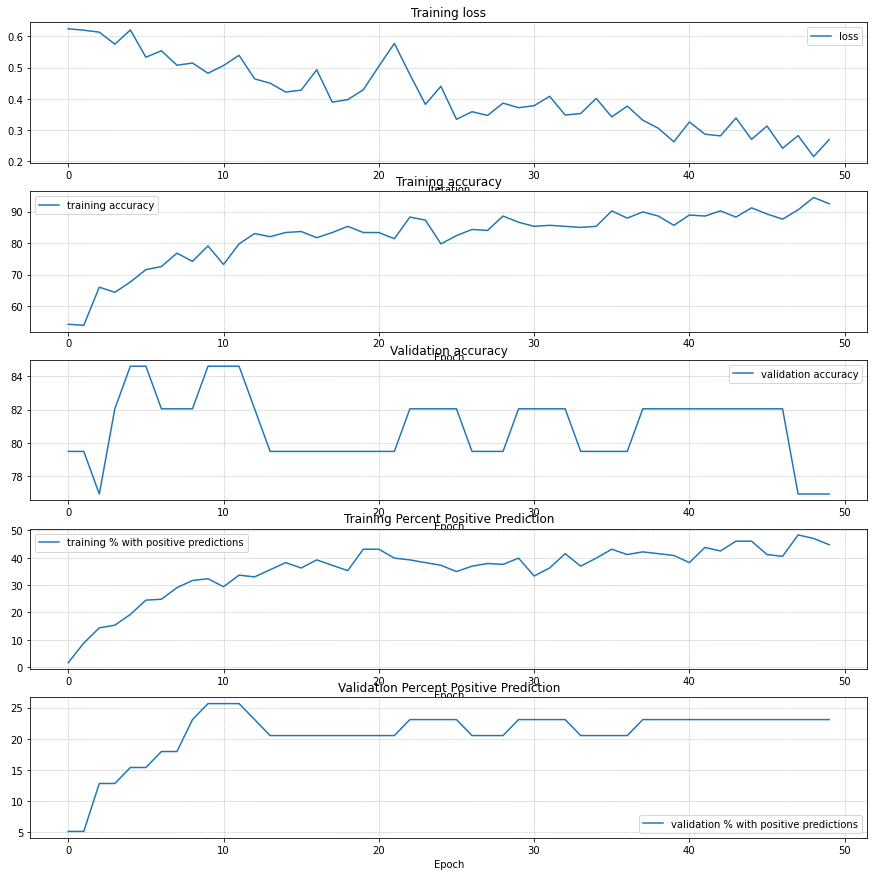

In [21]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs, alternative oversampling 

In [22]:
# oversample the train/val data by increasing number of OA=1 and increasing overall dataset size
#train_val_data = pd.concat([train_data, val_data], axis=0)
index_0 = train_data.index[train_data['OA_check'] == 0.0].tolist()
class_0 = train_data.loc[index_0]
index_1 = train_data.index[train_data['OA_check'] == 1.0].tolist()
class_1 = train_data.loc[index_1]
class_count_0 = len(class_0)
class_1_over = class_1.sample(class_count_0, replace=True)
train_over = pd.concat([class_1_over, class_0], axis=0)
# shuffle the DataFrame rows
train_over = train_over.sample(frac = 1)

NUM_TRAIN_OS = len(train_over)

train = CustomDataset(dataframe=train_over, transform=transform)
loader_train_os2 = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN_OS)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 77061
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os2, loader_val, epochs=50)

Epoch 0, loss = 0.7098, train_acc = 52.0921, val_acc = 82.0513, train_pos = 2.0921, val_pos = 7.6923
Epoch 1, loss = 0.6294, train_acc = 62.3431, val_acc = 82.0513, train_pos = 12.3431, val_pos = 12.8205
Epoch 2, loss = 0.5733, train_acc = 67.7824, val_acc = 74.3590, train_pos = 19.8745, val_pos = 20.5128
Epoch 3, loss = 0.5423, train_acc = 73.0126, val_acc = 74.3590, train_pos = 26.3598, val_pos = 20.5128
Epoch 4, loss = 0.4831, train_acc = 79.2887, val_acc = 74.3590, train_pos = 33.4728, val_pos = 20.5128
Epoch 5, loss = 0.5941, train_acc = 80.7531, val_acc = 76.9231, train_pos = 35.3556, val_pos = 23.0769
Epoch 6, loss = 0.5238, train_acc = 83.0544, val_acc = 79.4872, train_pos = 37.2385, val_pos = 20.5128
Epoch 7, loss = 0.5182, train_acc = 84.3096, val_acc = 79.4872, train_pos = 38.0753, val_pos = 20.5128
Epoch 8, loss = 0.5145, train_acc = 84.5188, val_acc = 82.0513, train_pos = 38.2845, val_pos = 23.0769
Epoch 9, loss = 0.4076, train_acc = 84.3096, val_acc = 82.0513, train_pos =

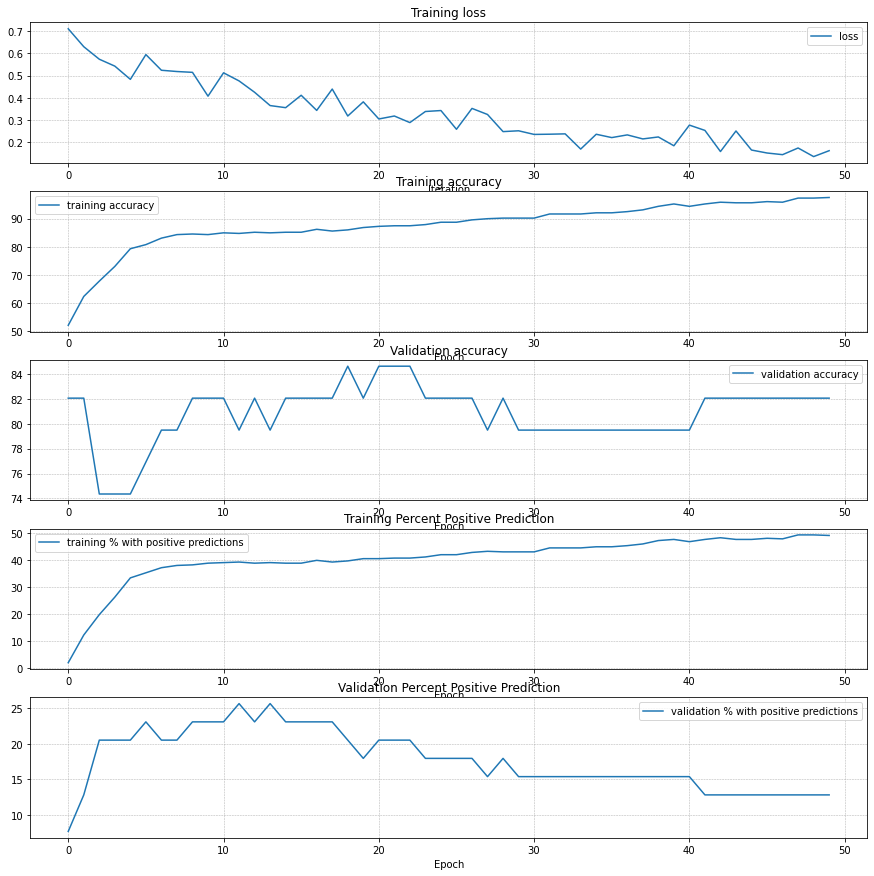

In [23]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling

In [24]:
train = CustomDataset(dataframe=train_data)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data)
loader_test = DataLoader(test, batch_size=64)

In [25]:
input_size = 77061
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50)

Epoch 0, loss = 109.6129, train_acc = 72.2222, val_acc = 41.0256, train_pos = 16.9935, val_pos = 69.2308
Epoch 1, loss = 94.9552, train_acc = 26.1438, val_acc = 53.8462, train_pos = 87.2549, val_pos = 41.0256
Epoch 2, loss = 266.9366, train_acc = 68.9542, val_acc = 79.4872, train_pos = 16.9935, val_pos = 0.0000
Epoch 3, loss = 49.2327, train_acc = 78.7582, val_acc = 76.9231, train_pos = 5.8824, val_pos = 7.6923
Epoch 4, loss = 47.1675, train_acc = 66.6667, val_acc = 51.2821, train_pos = 31.6993, val_pos = 48.7179
Epoch 5, loss = 17.6815, train_acc = 63.0719, val_acc = 79.4872, train_pos = 41.1765, val_pos = 10.2564
Epoch 6, loss = 40.5197, train_acc = 77.7778, val_acc = 76.9231, train_pos = 10.7843, val_pos = 2.5641
Epoch 7, loss = 19.1723, train_acc = 78.7582, val_acc = 79.4872, train_pos = 7.8431, val_pos = 5.1282
Epoch 8, loss = 15.1968, train_acc = 73.8562, val_acc = 79.4872, train_pos = 23.2026, val_pos = 15.3846
Epoch 9, loss = 16.5857, train_acc = 74.1830, val_acc = 82.0513, tra

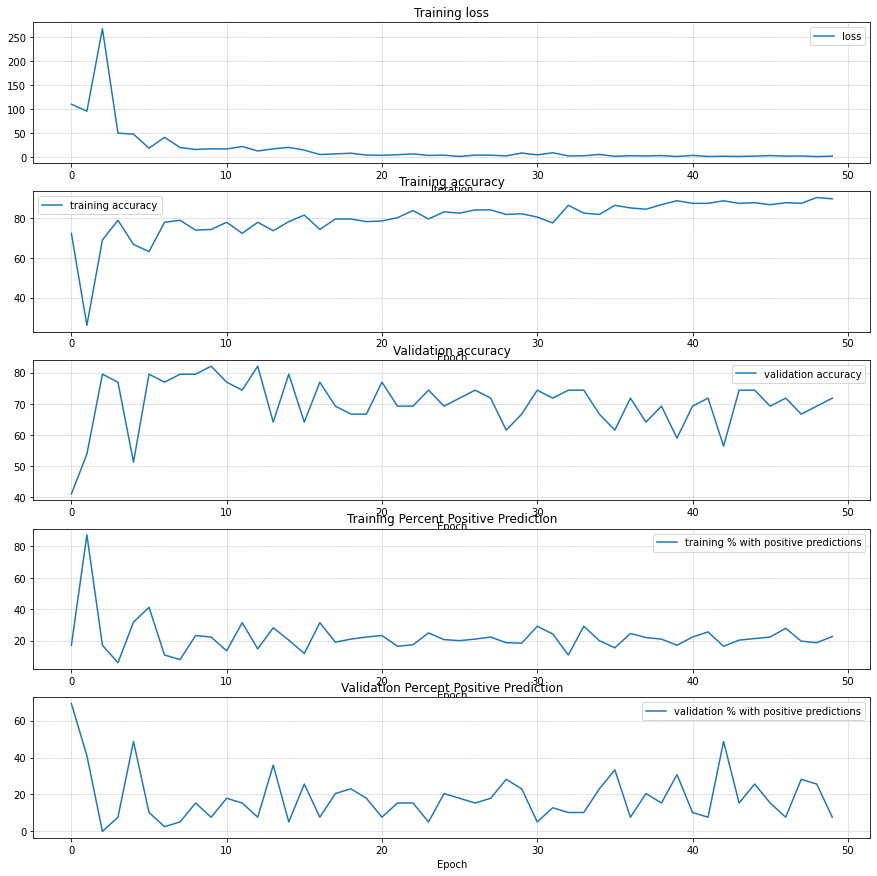

In [26]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling, weighted loss

In [31]:
# use weighted loss instead of oversampling 
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 77061
hidden_size = 2000
num_classes = 1

num_samples_pos = train_data[train_data['OA_check']==1].shape[0]
num_samples_neg = train_data[train_data['OA_check']==0].shape[0]
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50, \
    use_BCE_weight=True, num_samples_pos=num_samples_pos, num_samples_neg=num_samples_neg)

Epoch 0, loss = 10.8692, train_acc = 56.3433, val_acc = 25.6410, train_pos = 32.0896, val_pos = 94.8718
Epoch 1, loss = 18.4646, train_acc = 50.9328, val_acc = 51.2821, train_pos = 88.2463, val_pos = 43.5897
Epoch 2, loss = 4.9943, train_acc = 54.2910, val_acc = 56.4103, train_pos = 25.9328, val_pos = 38.4615
Epoch 3, loss = 4.3810, train_acc = 53.5448, val_acc = 46.1538, train_pos = 64.3657, val_pos = 74.3590
Epoch 4, loss = 8.3446, train_acc = 52.4254, val_acc = 56.4103, train_pos = 55.4104, val_pos = 38.4615
Epoch 5, loss = 9.7463, train_acc = 50.0000, val_acc = 43.5897, train_pos = 56.3433, val_pos = 56.4103
Epoch 6, loss = 2.1107, train_acc = 51.4925, val_acc = 53.8462, train_pos = 50.7463, val_pos = 46.1538
Epoch 7, loss = 2.0126, train_acc = 51.1194, val_acc = 58.9744, train_pos = 52.6119, val_pos = 41.0256
Epoch 8, loss = 2.5112, train_acc = 54.4776, val_acc = 61.5385, train_pos = 53.7313, val_pos = 33.3333
Epoch 9, loss = 2.2059, train_acc = 54.6642, val_acc = 61.5385, train_p

Epoch 79, loss = 0.4883, train_acc = 70.3358, val_acc = 71.7949, train_pos = 41.6045, val_pos = 43.5897
Epoch 80, loss = 0.5715, train_acc = 71.0821, val_acc = 71.7949, train_pos = 43.0970, val_pos = 33.3333
Epoch 81, loss = 0.5267, train_acc = 70.3358, val_acc = 74.3590, train_pos = 41.9776, val_pos = 25.6410
Epoch 82, loss = 0.5121, train_acc = 69.5896, val_acc = 71.7949, train_pos = 37.8731, val_pos = 38.4615
Epoch 83, loss = 0.9791, train_acc = 72.0149, val_acc = 66.6667, train_pos = 40.2985, val_pos = 53.8462
Epoch 84, loss = 0.7475, train_acc = 65.8582, val_acc = 71.7949, train_pos = 47.2015, val_pos = 33.3333
Epoch 85, loss = 0.8292, train_acc = 69.0299, val_acc = 84.6154, train_pos = 38.0597, val_pos = 15.3846
Epoch 86, loss = 0.7523, train_acc = 70.5224, val_acc = 74.3590, train_pos = 41.7910, val_pos = 41.0256
Epoch 87, loss = 0.4840, train_acc = 68.4701, val_acc = 82.0513, train_pos = 40.4851, val_pos = 28.2051
Epoch 88, loss = 0.5572, train_acc = 70.3358, val_acc = 79.4872,

Epoch 158, loss = 0.4270, train_acc = 69.4030, val_acc = 76.9231, train_pos = 51.1194, val_pos = 2.5641
Epoch 159, loss = 0.4159, train_acc = 71.2687, val_acc = 76.9231, train_pos = 36.5672, val_pos = 33.3333
Epoch 160, loss = 0.5946, train_acc = 72.7612, val_acc = 76.9231, train_pos = 39.1791, val_pos = 33.3333
Epoch 161, loss = 0.5766, train_acc = 68.8433, val_acc = 82.0513, train_pos = 40.1119, val_pos = 28.2051
Epoch 162, loss = 0.4837, train_acc = 70.7090, val_acc = 82.0513, train_pos = 45.3358, val_pos = 28.2051
Epoch 163, loss = 0.6669, train_acc = 73.5075, val_acc = 79.4872, train_pos = 39.9254, val_pos = 15.3846
Epoch 164, loss = 0.3803, train_acc = 73.5075, val_acc = 71.7949, train_pos = 40.2985, val_pos = 38.4615
Epoch 165, loss = 0.5021, train_acc = 75.1866, val_acc = 82.0513, train_pos = 42.7239, val_pos = 17.9487
Epoch 166, loss = 0.5509, train_acc = 71.6418, val_acc = 84.6154, train_pos = 37.3134, val_pos = 20.5128
Epoch 167, loss = 0.5535, train_acc = 70.8955, val_acc =

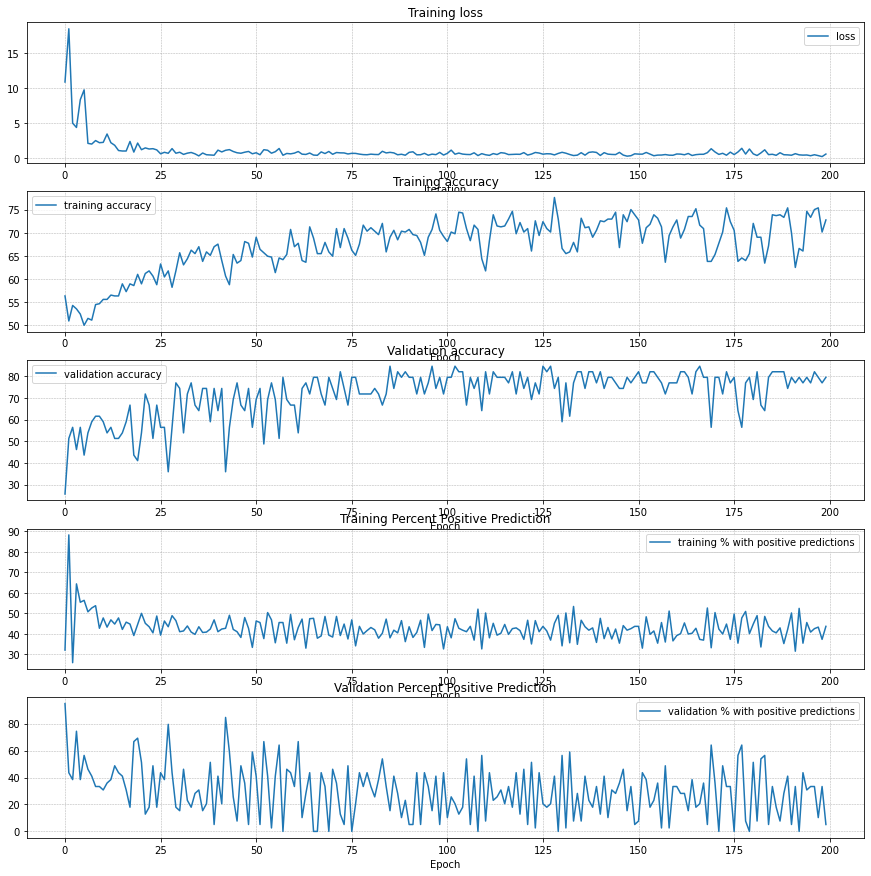

In [32]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()